In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
def read_energy_xvg(filename):
    # read xvg generated by gmx_energy
    energy_df =  pd.read_csv(
        filename, 
        skiprows=27, 
        sep='\s+',
        names=['t', 'electro', 'lj', 'electro_long', 'lj_long'],
        index_col='t',
        usecols=['t', 'electro', 'lj']
    )
    # calculate total energy
    energy_df['total'] = energy_df['electro'] + energy_df['lj']
    return energy_df


def avg_energy(df_list, column_list=None, start_time=150000, end_time=250000):
    if column_list is None:
        print('please supply list of column names.')
        return
    averages = []
    deviations = []
    for col in column_list:
        # all energies in kJ/mol
        energy = np.column_stack([
            df_list[0].loc[start_time:end_time, col].values,
            df_list[1].loc[start_time:end_time, col].values,
            df_list[2].loc[start_time:end_time, col].values,
        ])
        avg_energy = np.mean(energy, axis=0)
        energy_mean = np.mean(avg_energy)
        energy_std = np.std(avg_energy)

        averages.append(energy_mean)
        deviations.append(energy_std)

        print(f'{col}: {energy_mean:.3}, {energy_std:.3}')
        
    energy_table = np.stack([np.array(averages), np.array(deviations)])
    
    return pd.DataFrame(energy_table, columns=column_list)


def plot_energy(
    df, 
    column_list=None, 
    chunksize=100, 
    figsize=(15, 5),
    xlim=(0, 150),
    ylim=(-250, 0),
    savefile=None,
):
    if column_list is None:
        print('please supply list of column names.')
        return
    
    running_stats = []
    for idx, col in enumerate(column_list):
        energy_running = np.zeros(int(len(df[col])/chunksize))
        for x in range(int(len(df[col])/chunksize)):
            energy_running[x] = df.iloc[x*chunksize:(x+1)*chunksize, idx].mean()
        running_stats.append(energy_running)
            
    running = pd.DataFrame(
        np.column_stack(running_stats), 
        index=df.index[:-1:chunksize],
        columns=column_list,
    )
    
    colors = ['tab:blue', 'tab:orange']
    plt.figure(figsize=figsize)
    for idx, col in enumerate(column_list):
        plt.plot(df.index.values/1000, df[col], alpha=0.5, color=colors[idx])  
        plt.plot(running.index.values/1000, running[col], label=col, color=colors[idx])
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('time (ns)')
    plt.ylabel('energy (kJ/mol)')
    #plt.legend()
    if savefile is not None:
        plt.savefig(savefile, bbox_inches='tight', dpi=300)
        

def plot_energy_dist(dfs, start_time=50000, savefile=None):
    all_electro = np.stack([df.loc[start_time:, 'electro'].values for df in dfs])
    all_lj = np.stack([df.loc[start_time:, 'lj'].values for df in dfs])

    f = plt.figure(figsize=(5, 1.5))
    hist, edges = np.histogram(all_electro, bins=50, density=True)
    electro_max = np.max(hist)

    hist0, edges0 = np.histogram(all_lj, bins=50, density=True)
    lj_max = np.max(hist0)

    ax = f.add_subplot(111)
    # plot electrostatics
    ax.fill_between(edges[:-1], hist, alpha=0.3, color='tab:blue')
    ax.plot(
        [edges[np.argmax(hist)], edges[np.argmax(hist)]], 
        [0, 0.05],
        color='tab:blue'
    )

    ax.fill_between(edges0[:-1], hist0, alpha=0.3, color='tab:orange')
    ax.plot(
        [edges0[np.argmax(hist0)], edges0[np.argmax(hist0)]], 
        [0, 0.05],
        color='tab:orange'
    )
    #ax.yaxis.tick_right()

    # plot pdb structure values
    plt.plot([-58.48, -58.48], [0, 0.05], ls='--', color='tab:blue')
    plt.plot([-56.02, -56.02], [0, 0.05], ls='--', color='tab:orange')

    plt.legend(['electro', 'lj'])
    plt.xlim([-25, -275])
    plt.ylim([0, 0.05])
    plt.ylabel('prob')
    plt.xlabel('energy (kJ/mol)')
    if savefile is not None:
        plt.savefig(savefile, bbox_inches='tight', dpi=300)

# indoxyl sulfate

In [22]:
is1 = read_energy_xvg('data/indoxyl-sulfate/rerun/energy1.xvg')
is2 = read_energy_xvg('data/indoxyl-sulfate/rerun/energy2.xvg')
is3 = read_energy_xvg('data/indoxyl-sulfate/rerun/energy3.xvg')

print('Average energy (sem) across three IS simulations:')
avg_energy([is1, is2, is3], ['electro', 'lj', 'total'], start_time=50000, end_time=250000)

Average energy (sem) across three IS simulations:
electro: -1.14e+02, 6.12
lj: -1.03e+02, 1.68
total: -2.17e+02, 7.38


,electro,lj,total
0,-114.270245,-102.723688,-216.993934
1,6.120237,1.679460,7.381699


0
1
0
1
0
1


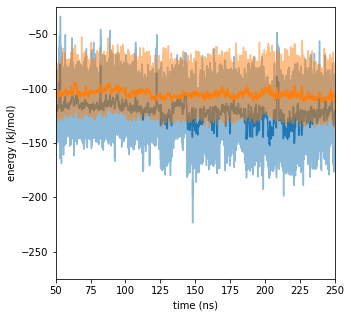

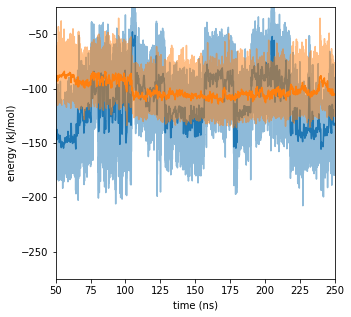

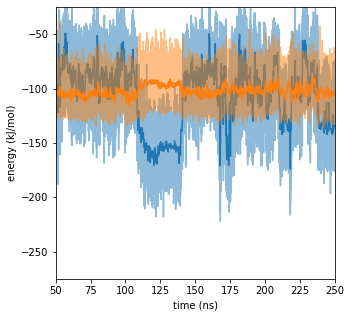

In [27]:
plot_energy(is1, ['electro', 'lj'], xlim=[50, 250], ylim=[-275, -25], figsize=(5, 5))
plot_energy(is2, ['electro', 'lj'], xlim=[50, 250], ylim=[-275, -25], figsize=(5, 5))
plot_energy(is3, ['electro', 'lj'], xlim=[50, 250], ylim=[-275, -25], figsize=(5, 5))

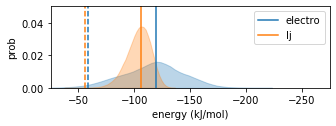

In [32]:
dfs = [is1, is2, is3]
plot_energy_dist(dfs)

# residue-wise energies

In [36]:
def plot_res_energies(
    energy_df, 
    #colors, 
    figsize=(5, 5), 
    savefile=None,
):
    # plot with error bars
    fig = plt.figure(figsize=figsize)

    
    # plot coulomb contributions of each residue
    coulomb_df = energy_df.iloc[:, :-2:2]
    ax = plt.subplot(1, 1, 1)
    ax.errorbar(
        range(len(coulomb_df.columns)), 
        coulomb_df.loc[0, :].values, 
        yerr=coulomb_df.loc[1, :].values,
        fmt='o',
        #alpha=0.5,
        color='tab:blue',
        label='electro'
    )
    plt.xticks(
        ticks=[idx for idx, val in enumerate(coulomb_df.columns)], 
        labels=[cv[:4] for cv in coulomb_df.columns], 
        rotation=45
    )
    
    # plot LJ contributions of each residue
    lj_df = energy_df.iloc[:, 1:-2:2]
    #ax = plt.subplot(1, 2, 2)
    ax.errorbar(
        range(len(lj_df.columns)), 
        lj_df.loc[0, :].values, 
        yerr=lj_df.loc[1, :].values,
        fmt='o',
        #alpha=0.5,
        color='tab:orange',
        label='lj'
    )
    plt.xticks(
        ticks=[idx for idx, val in enumerate(lj_df.columns)], 
        labels=[cv[:4] for cv in lj_df.columns], 
        rotation=45
    )
    plt.xlim(-1, len(lj_df.columns) + 0.2)
    plt.ylim(-75, 5)
    plt.ylabel('energy (kJ/mol)')
    plt.legend(loc=4)
    plt.plot([-1, 10], [0, 0], ls='--', c='k', alpha=0.3)
    
    
    if savefile is not None:
        plt.savefig(savefile, bbox_inches='tight', dpi=300)

In [33]:
import os.path as op

data_dir = 'data/indoxyl-sulfate/rerun/'
columns = [
    't', 'L383_electro', 'L383_lj', 'N387_electro', 'N387_lj', 
    'R406_electro', 'R406_lj', 'Y407_electro', 'Y407_lj', 
    'K410_electro', 'K410_lj', 'L426_electro', 'L426_lj', 
    'V429_electro', 'V429_lj', 'L449_electro', 'L449_lj', 
    'S485_electro', 'S485_lj', 'rest_electro', 'rest_lj'
]

is_list = [
    pd.read_csv(
        op.join(data_dir, f'residue_energy{idx}.xvg'), 
        skiprows=43, 
        sep='\s+',
        names=columns,
        index_col='t',
    ) 
    for idx in range(1, 4)
]

In [34]:
is_energies = avg_energy(is_list, columns[1:], start_time=50000, end_time=250000)

L383_electro: -2.15, 0.0935
L383_lj: -9.09, 0.513
N387_electro: -5.3, 2.82
N387_lj: -12.9, 0.549
R406_electro: -30.9, 12.3
R406_lj: -3.41, 1.11
Y407_electro: -30.8, 5.08
Y407_lj: -2.22, 0.161
K410_electro: -8.74, 5.69
K410_lj: -1.06, 0.357
L426_electro: -11.4, 1.89
L426_lj: -10.1, 0.268
V429_electro: 0.275, 0.199
V429_lj: -8.25, 0.439
L449_electro: -1.96, 0.327
L449_lj: -12.3, 0.77
S485_electro: -14.9, 6.6
S485_lj: -1.79, 0.0392
rest_electro: -8.32, 1.57
rest_lj: -41.6, 2.08


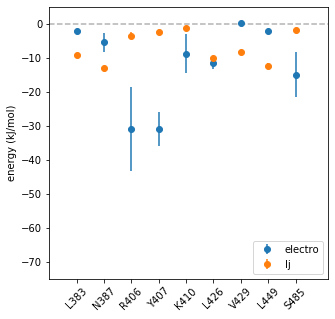

In [37]:
plot_res_energies(is_energies)